In [1]:
using Gen, Plots, LinearAlgebra

In [1048]:
# Utility Functions
function getRotationMatrix(theta)
    return [cos(theta) -sin(theta); sin(theta) cos(theta)]
end

function makeBox(theta, scale)
    normals = [[0.0, -1.0], [1.0, 0.0], [0.0, 1.0], [-1.0, 0.0]]
    corners = [[1.0,1.0], [-1.0,1.0], [-1.0,-1.0], [1.0,-1.0]]
    for i in 1:4
        normals[i] = getRotationMatrix(theta) * normals[i]
        corners[i] = getRotationMatrix(theta) * corners[i] * scale
    end
    box = vcat(normals, corners)
    return box
end

function isInBox(box, point, scale)
    ABn = box[1] # normal defining AB
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    # dot product with normal (check which side of the hyperspace the point is on)
    mAB = Transpose(ABn) * point + scale
    mBC = Transpose(BCn) * point + scale
    mCD = Transpose(CDn) * point + scale
    mDA = Transpose(DAn) * point + scale

    # get around floating point error
    epsilon = 0.0000001
    if mAB > -epsilon && mAB < epsilon
        mAB = 0.0
    end
    if mBC > -epsilon && mBC < epsilon
        mBC = 0.0
    end
    if mCD > -epsilon && mCD < epsilon
        mCD = 0.0
    end
    if mDA > -epsilon && mDA < epsilon
        mDA = 0.0
    end
    
    # dot product should be => 0 for all if the point is in the box
    if mAB < 0 
        return false
    end
     if mBC < 0
        return false
    end
    if mCD < 0
        return false
    end
    if mDA < 0
        return false
    end
    return true
end

# find the point of collision, normal at collision, and time of collision
# time of collision = Inf if there is no collision
function findIntersectionWithTrajectory(box, scale, O, V)
    # normals for each side of box
    ABn = box[1] # normal defining AB (facing inward)
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    tAB = Inf
    tBC = Inf
    tBC = Inf
    tDA = Inf

    # time of collision with each side of box
    tAB = (-scale - (ABn[1]* O[1]) - (ABn[2]* O[2]))/(ABn[1]*V[1] + ABn[2]*V[2])
    tBC = (-scale - (BCn[1]* O[1]) - (BCn[2]* O[2]))/(BCn[1]*V[1] + BCn[2]*V[2])
    tCD = (-scale - (CDn[1]* O[1]) - (CDn[2]* O[2]))/(CDn[1]*V[1] + CDn[2]*V[2])
    tDA = (-scale - (DAn[1]* O[1]) - (DAn[2]* O[2]))/(DAn[1]*V[1] + DAn[2]*V[2])

    # filter out "collision" if it happens in negative time
    if tAB == -Inf || tAB < 0 
        tAB = Inf
    end
    if tBC == -Inf || tBC < 0
        tBC = Inf
    end
    if tCD == -Inf || tCD < 0
        tCD = Inf
    end
    if tDA == -Inf || tDA < 0
        tDA = Inf
    end

    # find closest positive time of collision AKA the side of the box that the ball collides with
    current = Inf
    p = [Inf;Inf]
    n = [0.0;0.0]
    if tAB < current
        temp_p = O + V*tAB
        if isInBox(box, temp_p, scale)
            current = tAB
            p = O + V*tAB
            n = ABn
        end
    end
    if tBC < current
        temp_p = O + V*tBC
        if isInBox(box, temp_p, scale)
            current = tBC
            p = O + V*tBC
            n = BCn
        end
    end
    if tCD < current
        temp_p = O + V*tCD
        if isInBox(box, temp_p, scale)
            current = tCD
            p = O + V*tCD
            n = CDn
        end
    end
    if tDA < current
        temp_p = O + V*tDA
        if isInBox(box, temp_p, scale)
            current = tCD
            p = O + V*tCD
            n = DAn
        end
    end
    
    print(tAB)
    print(" ")
    print(tBC)
    print(" ")
    print(tCD)
    print(" ")
    print(tDA)

    return (p, -n, current) #(point of intersection, -n so the n points outward, time of intersection)
end


# get the velocity after colliding with the object
function getOutVector(V_in, p, n)
    O_out = p 
    V_out = V_in - 2 * (Transpose(V_in) * n) * n # velocity after hitting the object
    return O_out, V_out
end

# putting it all together
function getOutTrajectory(box, scale, O_in, V_in)
    p,n,t_out = findIntersectionWithTrajectory(box, scale, O_in, V_in) 
    O_out, V_out = getOutVector(V_in, p, n)
    return O_out, V_out, t_out
end

getOutTrajectory (generic function with 1 method)

In [1089]:
# no distinction between in and out trajectory for the random generated things
@gen function line_model(O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y, box)
    # jitterv = 0.15
    # jitterpos = 0.05
    jitterv = 0.15
    jitterpos = 0.05
    V_in_x = ({:V_in_x} ~ normal(V_in[1], jitterv))
    V_in_y = ({:V_in_y} ~ normal(V_in[2], jitterv))

    O_out_x = ({:O_out_x} ~ normal(O_out[1], jitterpos))
    O_out_y = ({:O_out_y} ~ normal(O_out[2], jitterpos))
    
    V_out_x = ({:V_out_x} ~ normal(V_out[1], jitterv))
    V_out_y = ({:V_out_y} ~ normal(V_out[2], jitterv))

    function x_in(t)
        return O_in[1] + V_in_x * t
    end

    function y_in(t)
        return O_in[2] + V_in_y * t
    end

    function x_out(t)
        return O_out_x + V_out_x * (t - t_out)
    end

    function y_out(t)
        return O_out_y + V_out_y * (t - t_out)
    end
    
    i_in_count= 0 #how many time steps before hit
    i_out_count = 0 #how many time steps after hit
    for (i, t) in enumerate(ts)
        if t < t_out #trajectory before hit object
            i_in_count = i
            ({(:x, i)} ~ normal(x_in(t), jitter_x))
            ({(:y, i)} ~ normal(y_in(t), jitter_y))
        else #trajectory after hit object
            i_out_count += 1
            ({(:x, i)} ~ normal(x_out(t), jitter_x))
            ({(:y, i)} ~ normal(y_out(t), jitter_y))
        end
    end

    return x_in, y_in, x_out, y_out, i_in_count, i_out_count
end;

In [1090]:
# no distinction between in and out
function render_trace(trace; show_data=true)
    # Pull out ts from the trace
    O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y, box = get_args(trace)
    
    # Pull out the return value, useful for plotting
   x_in, y_in, x_out, y_out, i_in_count, i_out_count = get_retval(trace)
    
    fig = plot(color="black", label=nothing,
                xlim=(-15, 15), ylim=(-15, 15))

    test_xs = collect(range(-30, stop=30, length=1000))
    # plot!(map(x -> x[1],map(y_in, ts[1:i_in_count])), map(x -> x[2],map(y_in, ts[1:i_in_count])), color="blue", alpha=1, label=nothing)
    plot!(map(x_in, ts[1:i_in_count]), map(y_in, ts[1:i_in_count]), color="green", alpha=1, label=nothing)
    plot!(map(x_out, ts[i_in_count:i_in_count+i_out_count]), map(y_out, ts[i_in_count:i_in_count+i_out_count]), color="green", alpha=1, label=nothing)
    

    # plot the box
    A, B, C, D, E = box[5], box[6],  box[7],  box[8],  box[5]
    plot!([A[1],B[1],C[1],D[1],E[1]],[A[2],B[2],C[2],D[2],E[2]],
      color=:red, linewidth=2, linestyle=:solid, label="Collision box")


    # plot the path
    if show_data
        x_in = [trace[(:x, i)] for i=1:i_in_count]
        y_in = [trace[(:y, i)] for i=1:i_in_count]
        scatter!(x_in, y_in, c="blue", label="In trajectory")

        if i_out_count > 0
            x_out = [trace[(:x, i)] for i=i_in_count:i_in_count+i_out_count]
            y_out = [trace[(:y, i)] for i=i_in_count:i_in_count+i_out_count]
            scatter!(x_out, y_out, c="green", label="Out trajectory")
        end
        
    end
    
    return fig
end;

In [1091]:
function grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;

In [1092]:
function do_inference(model, xs, ys, amount_of_computation, O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y, box)
    observations = Gen.choicemap()
    for (i, x) in enumerate(xs)
        observations[(:x, i)] = x
    end
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y, box), observations, amount_of_computation);
    return trace
end;

In [1103]:
function getAngle(trace)
    x_in, y_in, x_out, y_out, i_in_count, i_out_count = get_retval(trace)
    x1 = x_in(ts[1])
    y1 = y_in(ts[1])
    x2 = x_in(ts[i_in_count])
    y2 = y_in(ts[i_in_count])
    x3 = x_out(ts[i_in_count+1])
    y3 = y_out(ts[i_in_count+1])
    x4 = x_out(ts[i_in_count+i_out_count])
    y4 = y_out(ts[i_in_count+i_out_count])
    
    AB = normalize([x1;y1]-[x2;y2]) 
    BC = normalize([x4;y4]-[x3;y3])
    bisector = normalize(AB + BC) # tail to tail
    bisector
    # angle = sin(bisector[1])
    angle = 0
    if bisector[1] >= 0 && bisector[2] >= 0  #quadrant 1
        angle = acos(dot(bisector,[1.0;0.0]))
    elseif bisector[1] <= 0 && bisector[2] >= 0 # quadrant 2
        angle = acos(dot(bisector,[0.0;1.0]))
    elseif bisector[1] <= 0 && bisector[2] <= 0 #quadrant 3
        angle = acos(dot(bisector, [-1.0;0.0]))
    else
        angle = acos(dot(bisector,[0.0;-1.0])) # quadrant 4
    end
    return angle * 57.2958
end

getAngle (generic function with 1 method)

Inf 7.212034805874407 27.840261486507085 15.269888021631354

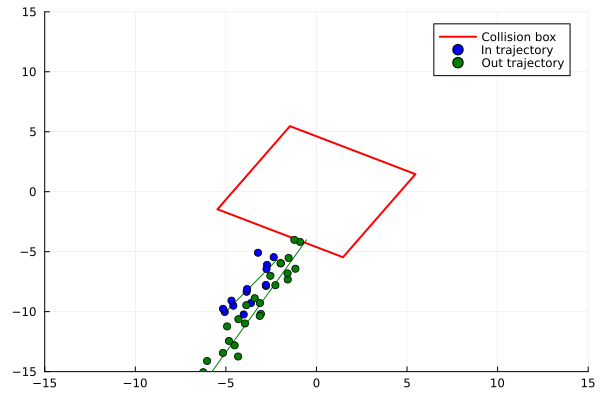

In [1110]:
scale = 4
theta =  60* 0.0174533 # degrees to radians
box = makeBox(theta,scale) 
O_in = [-5.0;-10.0]
V_in = normalize([3.0,4.0])
O_out, V_out, t_out = getOutTrajectory(box, scale, O_in, V_in)

ts = [0:0.5:20;]
jitter_x = 0.5
jitter_y = 0.5
x_in, y_in, x_out, y_out, i_in_count, i_out_count = line_model(O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y, box)
trace = Gen.simulate(line_model, (O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y, box));
choices = Gen.get_choices(trace)
render_trace(trace)

58.74315537535951

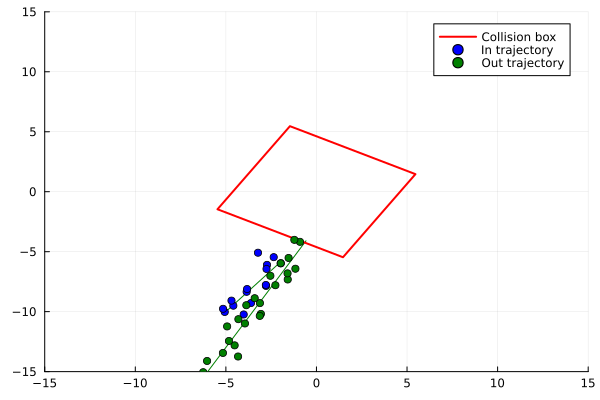

In [1112]:
all_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=1:i_in_count+i_out_count]
infTrace = do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 10, O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y,box);
angle = getAngle(infTrace)
print(angle)
render_trace(infTrace)


In [1102]:
# traces = [do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 15, O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y,box) for _=1:4];
# grid(render_trace, traces)

In [863]:
# traces = [do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 15, O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y,box) for _=1:4];
# grid(render_trace, traces)

# traces = [Gen.simulate(line_model, (O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y, box)) for _=1:5]
# grid(render_trace, traces)